# Travelling Salesperson Problem solved using genetic algorithms

In [33]:
# Imports 
import numpy as np
import random
import pandas as pd
from geopy import distance,geocoders,Nominatim # to calculate distance on the surface
import folium
from datetime import datetime

In [ ]:
# Parameters
n_cities = 10

n_population = 50

mutation_rate = 0.3

df = pd.read_csv('output.csv')

In [ ]:
# Generating a list of coordenades representing each city
coordinates_list = [[x,y] for x,y in zip(list(df['Latitude']),list(df['Longitude']))]
names_list = np.array(df['Street'])
cities_dict = { x:y for x,y in zip(names_list,coordinates_list)}

# Function to compute the distance between two points
def compute_city_distance_coordinates(a,b):
    return distance.distance((a[0], a[1]), (b[0],b[1])).km

def compute_city_distance_names(city_a, city_b, cities_dict):
    return compute_city_distance_coordinates(cities_dict[city_a], cities_dict[city_b])

cities_dict

{'53 Avenue des Champs-Elysees': [48.870137, 2.305385],
 '65 Boulevard Malesherbes': [48.876488, 2.31764],
 '4 Rue Boissieu': [48.884347, 2.349094],
 '96 Rue Daguerre': [48.836048, 2.32414],
 '11 Rue Notre-Dame de Lorette': [48.877498, 2.338302],
 '32 Rue des Saints-Peres': [48.855208, 2.330718],
 '10 Rue de la Butte aux Cailles': [48.827964, 2.351655],
 '183 Avenue Daumesnil': [48.840378, 2.392925],
 '56 Passage des Panoramas': [48.871466, 2.341826],
 '107 Rue de Patay': [48.827357, 2.371647]}

## 1. Create the first population set
We randomly shuffle the cities N times where N=population_size

In [ ]:
# First step: Create the first population set
def genesis(city_list, n_population):

    population_set = []
    for i in range(n_population):
        #Randomly generating a new solution
        sol_i = city_list[np.random.choice(list(range(n_cities)), n_cities, replace=False)]
        population_set.append(sol_i)
    return np.array(population_set)

population_set = genesis(names_list, n_population)
# population_set

## 2. Evaluate solutions fitness
The solutions are defined so that the first element on the list is the first city to visit, then the second, etc. and the last city is linked to the first.
The fitness function needs to compute the distance between subsequent cities.

In [ ]:
def fitness_eval(city_list, cities_dict):
    total = 0
    for i in range(n_cities-1):
        a = city_list[i]
        b = city_list[i+1]
        total += compute_city_distance_names(a,b, cities_dict)
    return total

In [ ]:
def get_all_fitnes(population_set, cities_dict):
    fitnes_list = np.zeros(n_population)

    #Looping over all solutions computing the fitness for each solution
    for i in  range(n_population):
        fitnes_list[i] = fitness_eval(population_set[i], cities_dict)

    return fitnes_list

fitnes_list = get_all_fitnes(population_set,cities_dict)
fitnes_list

array([44.25343279, 31.51660596, 34.91340175, 32.52837021, 39.48070119,
       38.69148829, 34.42068029, 43.41995499, 26.54791472, 30.78122772,
       30.40491998, 34.79771391, 40.96245928, 37.94293212, 37.82803519,
       25.85735026, 37.75081492, 29.94264775, 37.53618874, 25.20148048,
       36.9506678 , 36.02563854, 34.20996741, 27.60673818, 34.35559752,
       37.67530234, 40.5784466 , 35.1495214 , 38.10655645, 30.61410021,
       37.50769816, 33.08628624, 36.35951471, 35.2255979 , 32.77841355,
       36.6742612 , 37.91182117, 32.17500717, 36.25726292, 32.37775251,
       44.48960557, 36.29378217, 46.94757448, 44.87277755, 29.95322414,
       38.85874887, 32.52559327, 36.63264581, 34.4507867 , 41.71807939])

# 3. Progenitors selection
I will select a new set of progenitors using the Roulette Wheel Selection. Generates a list of progenitor pairs where N= len(population_set) but at each position there are two solutions to merge

In [ ]:
def progenitor_selection(population_set,fitnes_list):
    total_fit = fitnes_list.sum()
    prob_list = fitnes_list/total_fit
    
    #Notice there is the chance that a progenitor. mates with oneself
    progenitor_list_a = np.random.choice(list(range(len(population_set))), len(population_set),p=prob_list, replace=True)
    progenitor_list_b = np.random.choice(list(range(len(population_set))), len(population_set),p=prob_list, replace=True)
    
    progenitor_list_a = population_set[progenitor_list_a]
    progenitor_list_b = population_set[progenitor_list_b]
    
    
    return np.array([progenitor_list_a,progenitor_list_b])


progenitor_list = progenitor_selection(population_set,fitnes_list)
progenitor_list[0][2]

array(['10 Rue de la Butte aux Cailles', '53 Avenue des Champs-Elysees',
       '96 Rue Daguerre', '11 Rue Notre-Dame de Lorette',
       '65 Boulevard Malesherbes', '56 Passage des Panoramas',
       '183 Avenue Daumesnil', '32 Rue des Saints-Peres',
       '4 Rue Boissieu', '107 Rue de Patay'], dtype=object)

# 4. Mating
For each pair of  parents we'll generate an offspring pair. Since we cannot repeat cities what we'll do is copy a random chunk from one progenitor and fill the blanks with the other progenitor.

In [ ]:
def mate_progenitors(prog_a, prog_b):
    offspring = prog_a[0:5]

    for city in prog_b:

        if not city in offspring:
            offspring = np.concatenate((offspring,[city]))

    return offspring
            
    
    
def mate_population(progenitor_list):
    new_population_set = []
    for i in range(progenitor_list.shape[1]):
        prog_a, prog_b = progenitor_list[0][i], progenitor_list[1][i]
        offspring = mate_progenitors(prog_a, prog_b)
        new_population_set.append(offspring)
        
    return new_population_set

new_population_set = mate_population(progenitor_list)
new_population_set[0]

array(['10 Rue de la Butte aux Cailles', '32 Rue des Saints-Peres',
       '107 Rue de Patay', '56 Passage des Panoramas',
       '183 Avenue Daumesnil', '65 Boulevard Malesherbes',
       '11 Rue Notre-Dame de Lorette', '96 Rue Daguerre',
       '4 Rue Boissieu', '53 Avenue des Champs-Elysees'], dtype=object)

# 5. Mutation
Now for each element of the new population we add a random chance of swapping

In [ ]:
def mutate_offspring(offspring):
    for q in range(int(n_cities*mutation_rate)):
        a = np.random.randint(0,n_cities)
        b = np.random.randint(0,n_cities)

        offspring[a], offspring[b] = offspring[b], offspring[a]

    return offspring
    
    
def mutate_population(new_population_set):
    mutated_pop = []
    for offspring in new_population_set:
        mutated_pop.append(mutate_offspring(offspring))
    return mutated_pop

mutated_pop = mutate_population(new_population_set)
mutated_pop[0]

array(['10 Rue de la Butte aux Cailles', '32 Rue des Saints-Peres',
       '107 Rue de Patay', '56 Passage des Panoramas',
       '65 Boulevard Malesherbes', '183 Avenue Daumesnil',
       '11 Rue Notre-Dame de Lorette', '96 Rue Daguerre',
       '4 Rue Boissieu', '53 Avenue des Champs-Elysees'], dtype=object)

# 6. Stopping
To select the stopping criteria we'll need to create a loop to stop first. Then I'll set it to loop at 1000 iterations.

In [ ]:
best_solution = [-1,np.inf,np.array([])]
for i in range(1000):
    if i%100==0: print(i, fitnes_list.min(), fitnes_list.mean(), datetime.now().strftime("%d/%m/%y %H:%M"))
    fitnes_list = get_all_fitnes(mutated_pop,cities_dict)
    
    #Saving the best solution
    if fitnes_list.min() < best_solution[1]:
        best_solution[0] = i
        best_solution[1] = fitnes_list.min()
        best_solution[2] = np.array(mutated_pop)[fitnes_list.min() == fitnes_list]
    
    progenitor_list = progenitor_selection(population_set,fitnes_list)
    new_population_set = mate_population(progenitor_list)
    
    mutated_pop = mutate_population(new_population_set)

0 25.201480476708408 35.662945809016215 12/01/23 10:38
100 26.239908314447984 34.58817696046335 12/01/23 10:38
200 26.5577372853513 36.89079171547289 12/01/23 10:38
300 23.578552758328968 35.89819042715085 12/01/23 10:38
400 24.495645159091524 37.39040737557852 12/01/23 10:38
500 26.688543114776603 34.59802468213922 12/01/23 10:39
600 26.28921023469343 35.82429938621142 12/01/23 10:39
700 22.938301662998864 35.72805939188896 12/01/23 10:39
800 22.037320020395512 35.17317237690204 12/01/23 10:39
900 26.11696449763177 35.68675712071704 12/01/23 10:39


In [ ]:
best_solution

[983, 17.34105808229039, array([['183 Avenue Daumesnil', '107 Rue de Patay',
         '10 Rue de la Butte aux Cailles', '96 Rue Daguerre',
         '53 Avenue des Champs-Elysees', '65 Boulevard Malesherbes',
         '32 Rue des Saints-Peres', '56 Passage des Panoramas',
         '11 Rue Notre-Dame de Lorette', '4 Rue Boissieu']], dtype=object)]

In [31]:
best_road = best_solution[2][0]
best_road

array(['183 Avenue Daumesnil', '107 Rue de Patay',
       '10 Rue de la Butte aux Cailles', '96 Rue Daguerre',
       '53 Avenue des Champs-Elysees', '65 Boulevard Malesherbes',
       '32 Rue des Saints-Peres', '56 Passage des Panoramas',
       '11 Rue Notre-Dame de Lorette', '4 Rue Boissieu'], dtype=object)

In [32]:
cities_dict[best_road[0]]

[48.840378, 2.392925]

In [72]:
m = folium.Map(location=cities_dict[best_road[0]], zoom_start=12, tiles="Stamen Terrain")
loc = []
for el in best_road:
  loc.append(cities_dict[el])
  folium.Marker(
      cities_dict[el], popup=f"<i>{el}</i>"
  ).add_to(m)
loc.append(cities_dict[best_road[0]])
folium.PolyLine(loc,
                color='blue',
                weight=4,
                opacity=0.9).add_to(m)
m
m.save("heat_map.html")

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


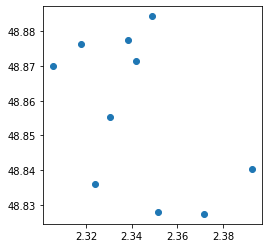

In [68]:
# !pip install geopandas
import pandas as pd
import geopandas
import folium
import matplotlib.pyplot as plt

# graph = geopandas.read_file('output.csv')
# graph.crs = {'init' :'epsg:4326'}

# m = folium.Map([48.2, 16.4], zoom_start=10)
 
# folium.Choropleth(
#     graph[graph.geometry.length>0.001],
#     line_weight=3,
#     line_color='blue'
# ).add_to(m)
 
# m


world = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

# world = geopandas.read_file(gdf)

# We restrict to South America.
world.crs = {'init' :'epsg:4326'}

world.plot()

In [81]:
import urllib.request
try:
    import tkinter as tk
except ImportError:
    import Tkinter as tk

from tkinterhtml import HtmlFrame

root = tk.Tk()

frame = HtmlFrame(root, horizontal_scrollbar="auto")
frame.grid(sticky=tk.NSEW)
 
 
frame.set_content("""
<html>
<body>
<h1>Hello world!</h1>
<p>First para</p>
<ul>
    <li>first list item</li>
    <li>second list item</li>
</ul>
<img src="http://findicons.com/files/icons/638/magic_people/128/magic_ball.png"/>
</body>
</html>    
""")
 
frame.set_content(urllib.request.urlopen("http://thonny.cs.ut.ee").read().decode())
#print(frame.html.cget("zoom"))


root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)
root.mainloop()

TclError: ignored